In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as akssh 
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
varinfo.clear()

In [4]:
module = fc.eightb.preselection.t8btag_minmass
dout = "mpbkg20_soft100_md"

In [5]:
# signal = ObjIter([])
signal = ObjIter([ Tree(f, report=False, altfile=f'{dout}_{{base}}') for f in tqdm(module.signal_list) ])
# signal = ObjIter([ Tree(f, report=False, altfile=f'{dout}_{{base}}') for f in tqdm(module.full_signal_list) ])

# bkg = ObjIter([])
bkg = ObjIter([ Tree(module.Run2_UL18.QCD_B_List, altfile=f'{dout}_{{base}}'), Tree(module.Run2_UL18.TTJets, altfile=f'{dout}_{{base}}')])

# data = ObjIter([])
data = ObjIter([ Tree(module.Run2_UL18.JetHT_Data_UL_List, altfile=f'{dout}_{{base}}') ])

100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


In [6]:
bkg.reweight(2.3)
bkg.set_systematics(0.2)

[None, None]

In [7]:
event_filter = FilterSequence(
    eightb.selected_jet_pt(),
    eightb.selected_jet_btagwp()
)

In [8]:
signal = signal.apply(event_filter)
bkg = bkg.apply(event_filter)
data = data.apply(event_filter)

100%|██████████| 4/4 [00:06<00:00,  1.64s/it]


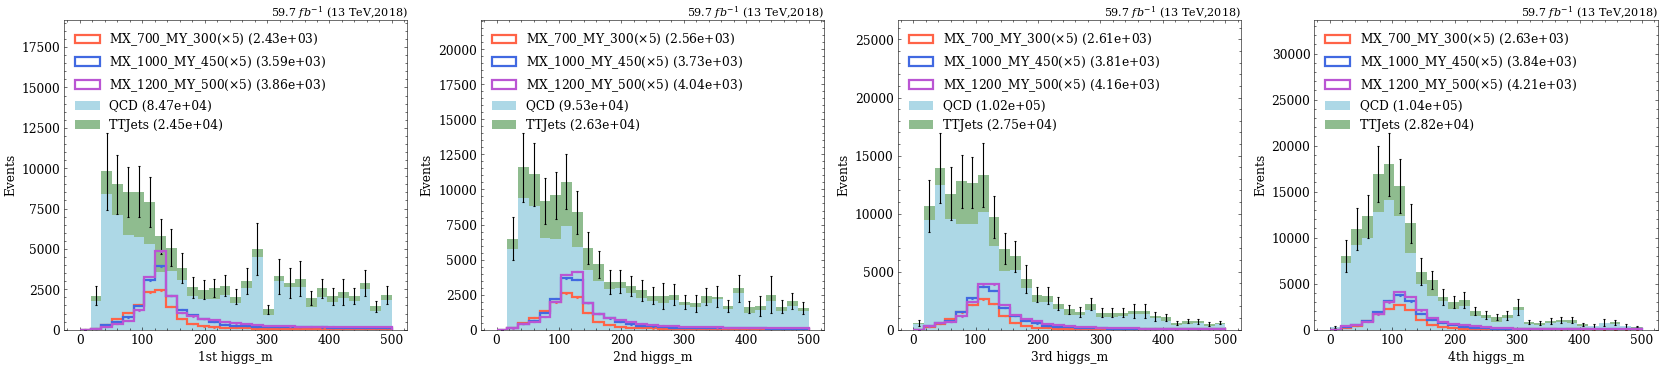

In [9]:
study.quick( 
    signal+bkg,
    plot_scale=[5]*3,
    legend=True,
    varlist=[f'higgs_m[:,{i}]' for i in range(4)],
    dim=-1,
    binlist=[(0,500,30)]*4,
    
    # efficiency=True,
)

In [10]:
varinfo.higgs_m = dict(bins=(0,500,30))
varinfo.higgs_dm = dict(bins=(0,500,30))


In [23]:
min_events = signal.apply(len).npy.min()

In [24]:
higgs_m = signal.higgs_m.apply(lambda m : m[:min_events]).cat.to_numpy()

In [41]:
def find_best(center):
    dm = np.abs(higgs_m - center)

    dm2 = ak.sum(dm**2,axis=-1)
    mask = dm2 < 10**2

    return 1-ak.mean(mask)

In [42]:
from scipy.optimize import fmin 

best_center = fmin(find_best, (125,125,125,125))
best_center

Optimization terminated successfully.
         Current function value: 0.996421
         Iterations: 44
         Function evaluations: 133


array([126.6789253 , 124.39662532, 122.05237774, 122.93992324])

100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


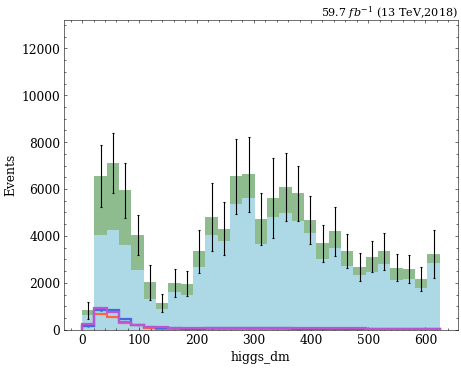

In [45]:
def get_higgs_dm(t, center=best_center):
    dm = ak.zeros_like(t.higgs_m[:,0])
    for i, m in enumerate(center):
        dm = dm + ( (t.higgs_m[:,i]-m) )**2
    dm = np.sqrt(dm)
    t.extend(higgs_dm=dm)
(signal+bkg).apply(get_higgs_dm)

study.quick( 
    signal+bkg,
    varlist=['higgs_dm'],
    binlist=[(0,5*125,30)]
)

100%|██████████| 34/34 [00:23<00:00,  1.43it/s]


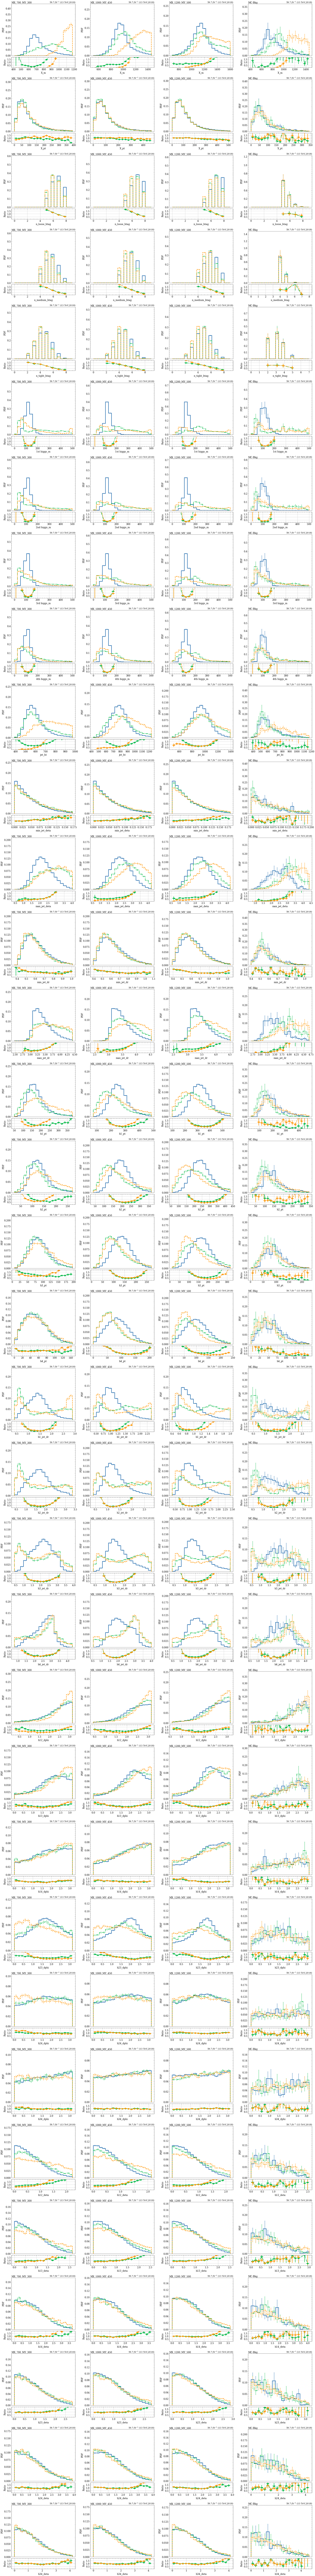

In [16]:
study.compare_masks(
    signal,bkg,
    h_color=None,
    masks=[lambda t : t.higgs_dm < 1, lambda t : (t.higgs_dm > 1) & (t.higgs_dm < 3), lambda t : t.higgs_dm > 3],
    varlist=['X_m','X_pt']+['n_loose_btag','n_medium_btag','n_tight_btag']+[f'higgs_m[:,{i}]' for i in range(4)]+eightb.bdt_features,
    efficiency=True,
    h_rebin=20,
    ratio=True, r_inv=True,
)

100%|██████████| 3/3 [00:02<00:00,  1.06it/s]


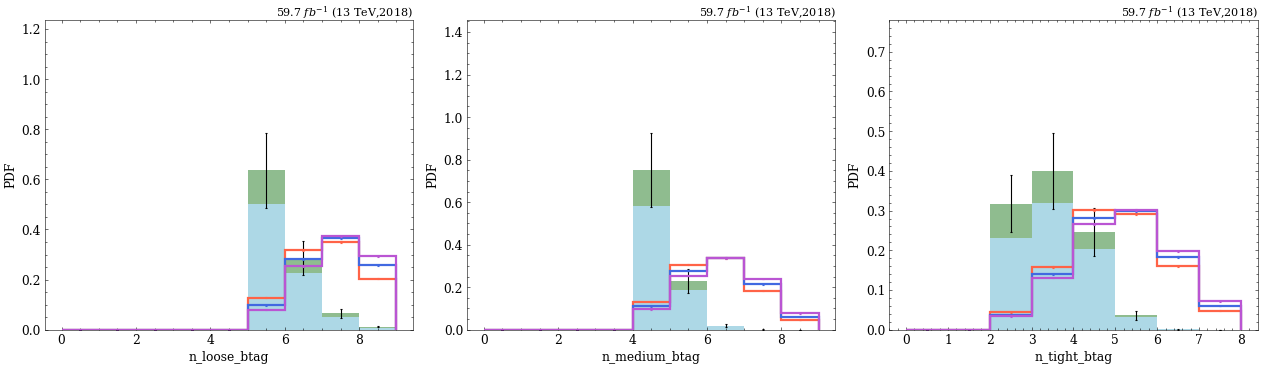

In [17]:
study.quick( 
    signal+bkg,
    varlist=['n_loose_btag','n_medium_btag','n_tight_btag'],
    efficiency=True,
    dim=-1,
)

100%|██████████| 31/31 [00:21<00:00,  1.46it/s]


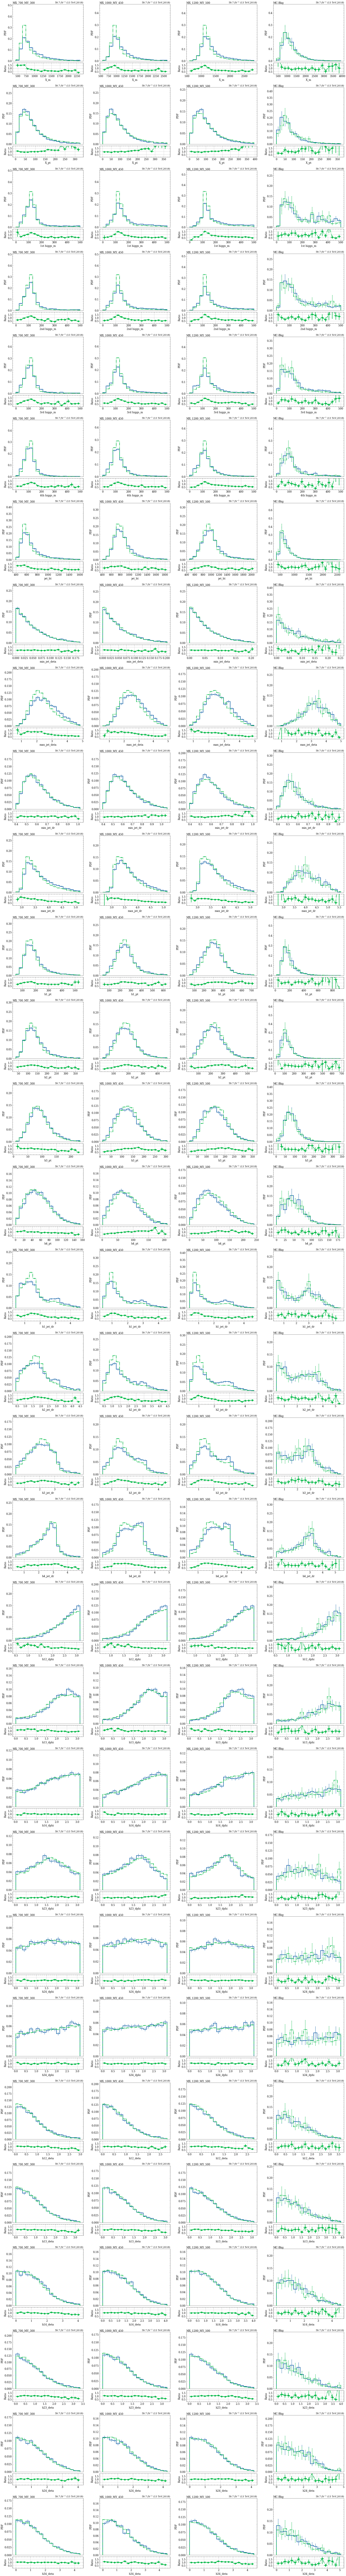

In [18]:
study.compare_masks(
    signal,bkg,
    h_color=None,
    masks=[lambda t : t.n_loose_btag==5,lambda t : t.n_loose_btag>=6],
    varlist=['X_m','X_pt']+[f'higgs_m[:,{i}]' for i in range(4)]+eightb.bdt_features,
    efficiency=True,
    h_rebin=20,
    ratio=True, r_inv=True,
)

100%|██████████| 3/3 [00:01<00:00,  2.64it/s]


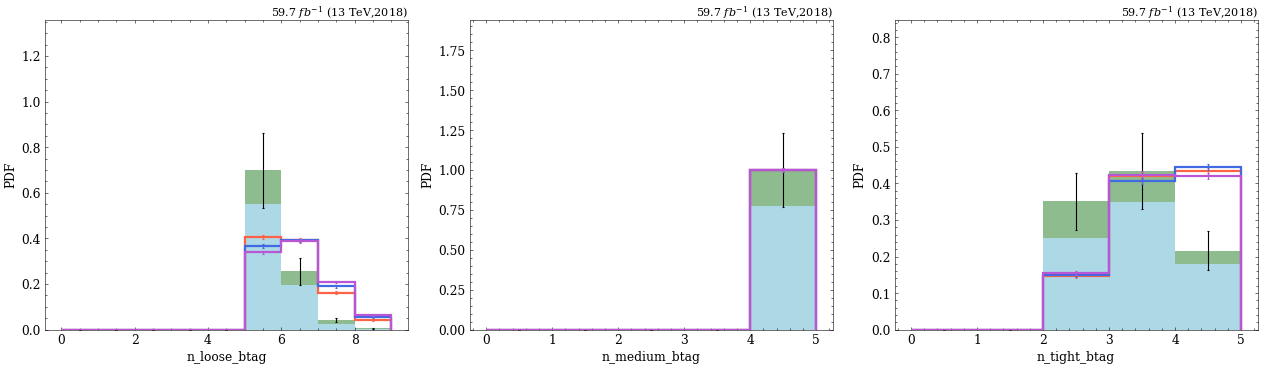

In [19]:
study.quick( 
    signal+bkg,
    masks=lambda t : t.n_medium_btag == 4,
    varlist=['n_loose_btag','n_medium_btag','n_tight_btag'],
    efficiency=True,
    dim=-1,
)

100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


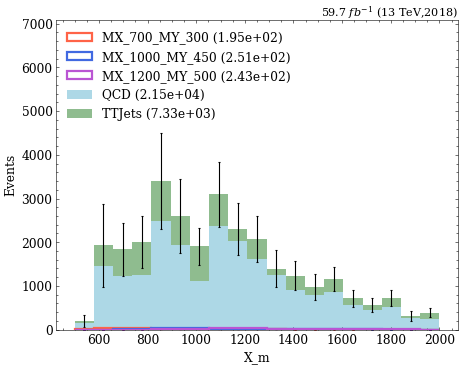

In [23]:
study.quick( 
    signal+bkg,
    legend=True,
    masks=lambda t : (t.n_medium_btag == 4)&(t.n_loose_btag >= 6),
    varlist=['X_m'],
    binlist=[(500,2000,20)],
    # efficiency=True,
    dim=-1,
)

In [24]:
validation = EventFilter('n_medium_btag==4', filter=lambda t : t.n_medium_btag==4)
val_data = data.apply(validation)
val_bkg = bkg.apply(validation)

100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


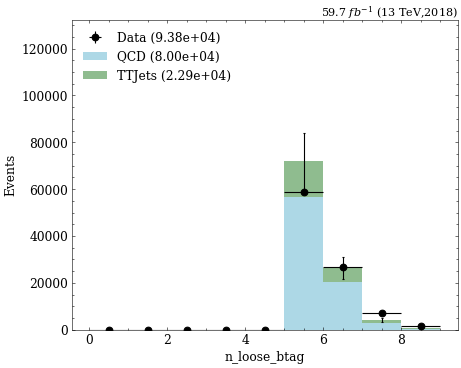

In [27]:
study.quick( 
    val_data+val_bkg,
    legend=True,
    varlist=['n_loose_btag'],
)

100%|██████████| 3/3 [00:34<00:00, 11.49s/it]


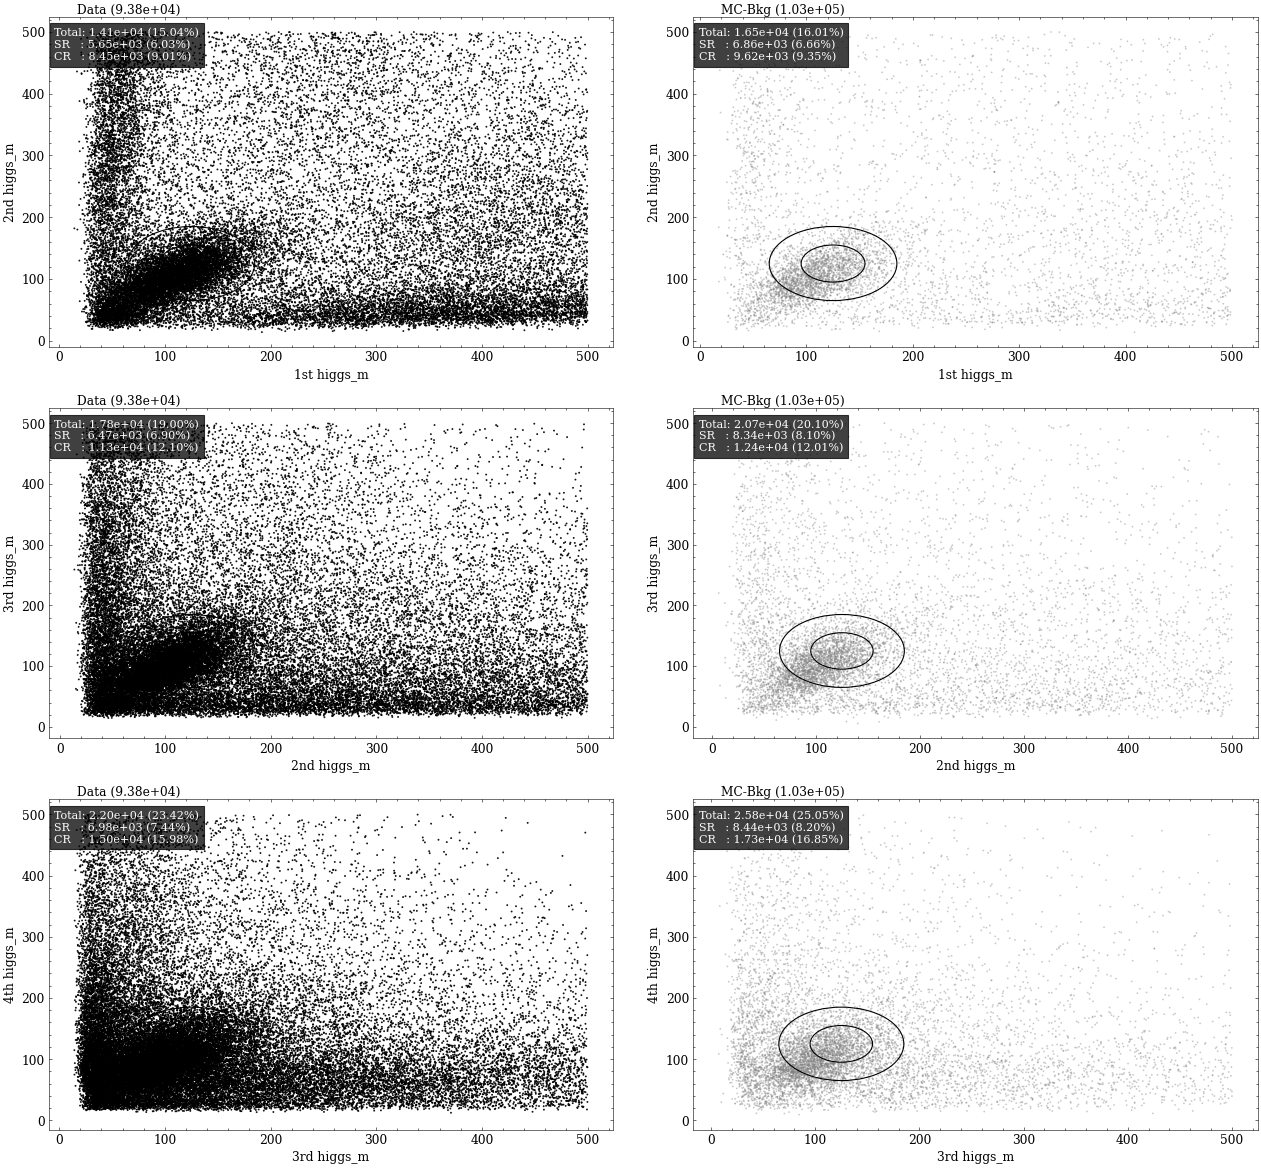

In [35]:
study.quick2d( 
    val_data+val_bkg,
    varlist=[f'higgs_m[:,{i}]' for i in [0,1,1,2,2,3]],
    dim=-1,
    binlist=[(0,500,30)]*6,
    exe=draw_concentric(x=125,y=125,r1=30,r2=60),
    scatter=True,    
    # efficiency=True,
)

100%|██████████| 1/1 [00:05<00:00,  5.66s/it]


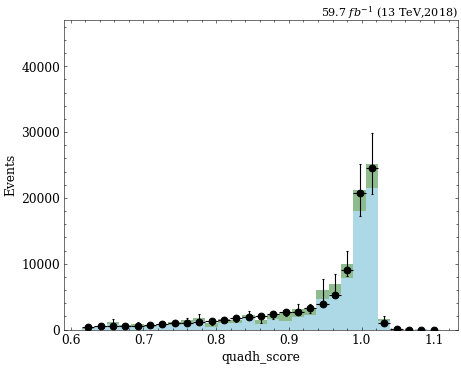

In [36]:
study.quick(
    val_data+val_bkg,
    varlist=['quadh_score']
)

In [40]:
from utils.classUtils.Filter import Filter

100%|██████████| 1/1 [00:06<00:00,  6.42s/it]


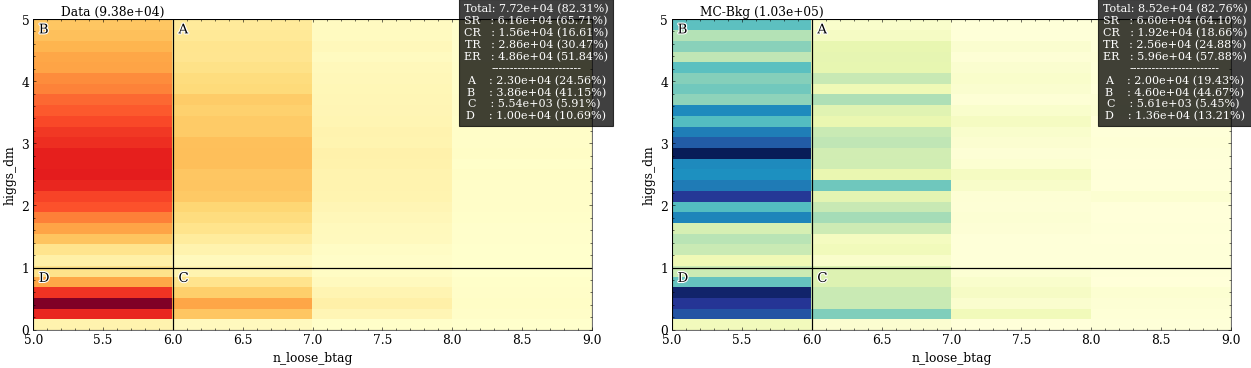

In [60]:
study.quick2d( 
    val_data+val_bkg,
    varlist=['n_loose_btag','higgs_dm'],
    binlist=[np.arange(5,10),(0,5,30)],
    exe=draw_abcd(x_r=(5,6,9),y_r=(0,1,5))
)

In [59]:
vr_bdt = ABCD(
    eightb.bdt_features,
    a=Filter(lambda t : (t.n_loose_btag >  5) & (t.higgs_dm < 1)),
    b=Filter(lambda t : (t.n_loose_btag == 5) & (t.higgs_dm < 1)),
    c=Filter(lambda t : (t.n_loose_btag >  5) & (t.higgs_dm > 1)),
    d=Filter(lambda t : (t.n_loose_btag == 5) & (t.higgs_dm > 1)),
)

In [61]:
val_model = val_data.asmodel('bkg model')

In [62]:
vr_bdt.train(val_model)
vr_bdt.print_results(val_model)

... fetching features
... splitting features
... calculating k factor
... fitting reweighter
--- ABCD Results ---
k = 6.083e-01
k*(b/a)-1  = 10.06%
BDT(b)/a-1 = 5.80%



100%|██████████| 8/8 [00:57<00:00,  7.17s/it]


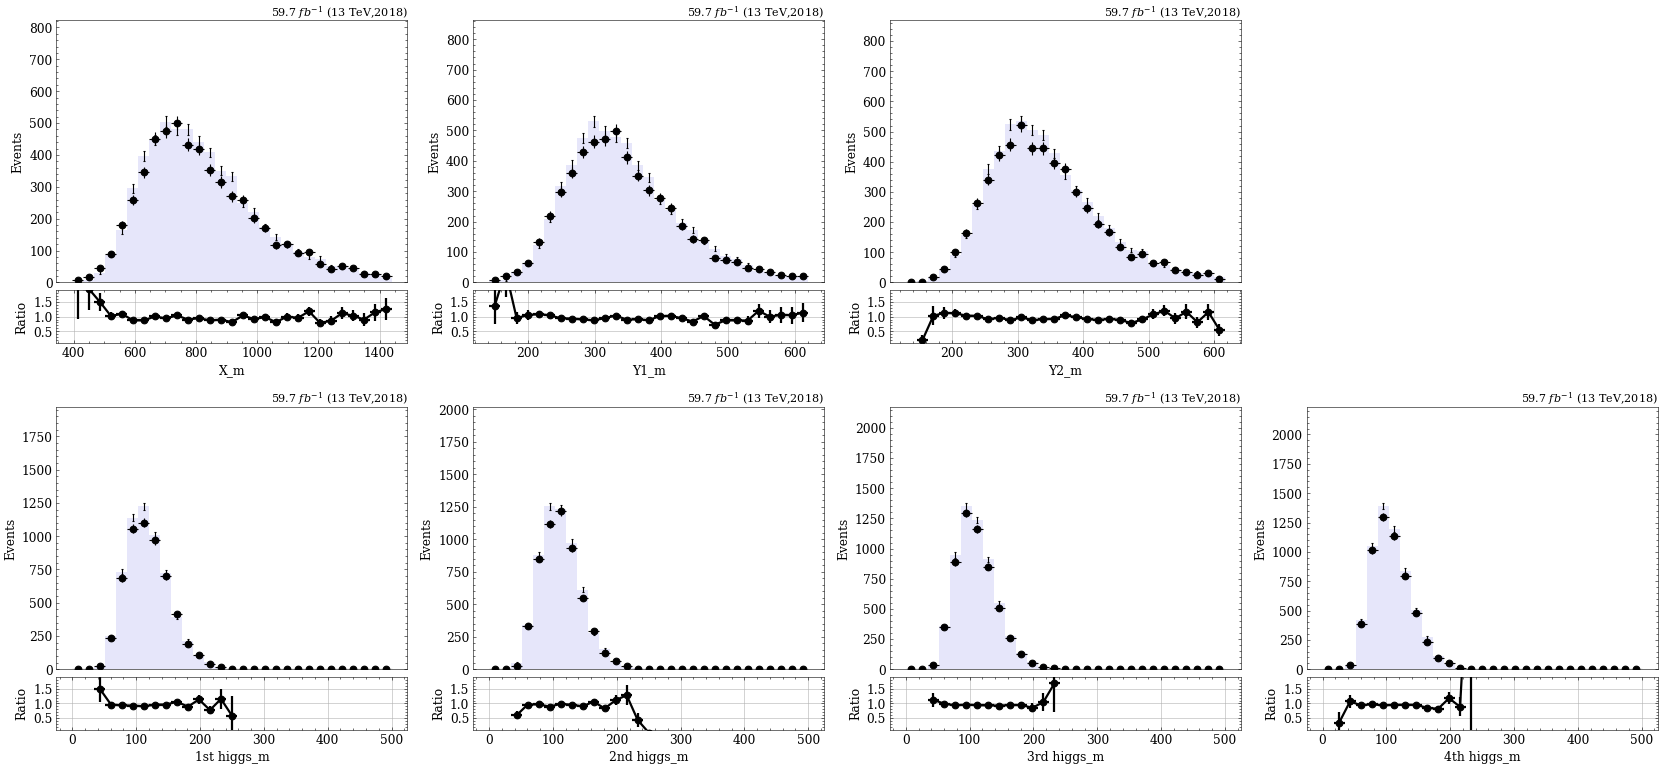

In [67]:
study.quick( 
    val_data+val_model,
    masks=[vr_bdt.a]+[vr_bdt.b],
    scale=[None]+[vr_bdt.reweight_tree],
    varlist=['X_m','Y1_m','Y2_m',None]+[f'higgs_m[:,{i}]' for i in range(4)],
    ratio=True,
)

100%|██████████| 25/25 [02:01<00:00,  4.87s/it]


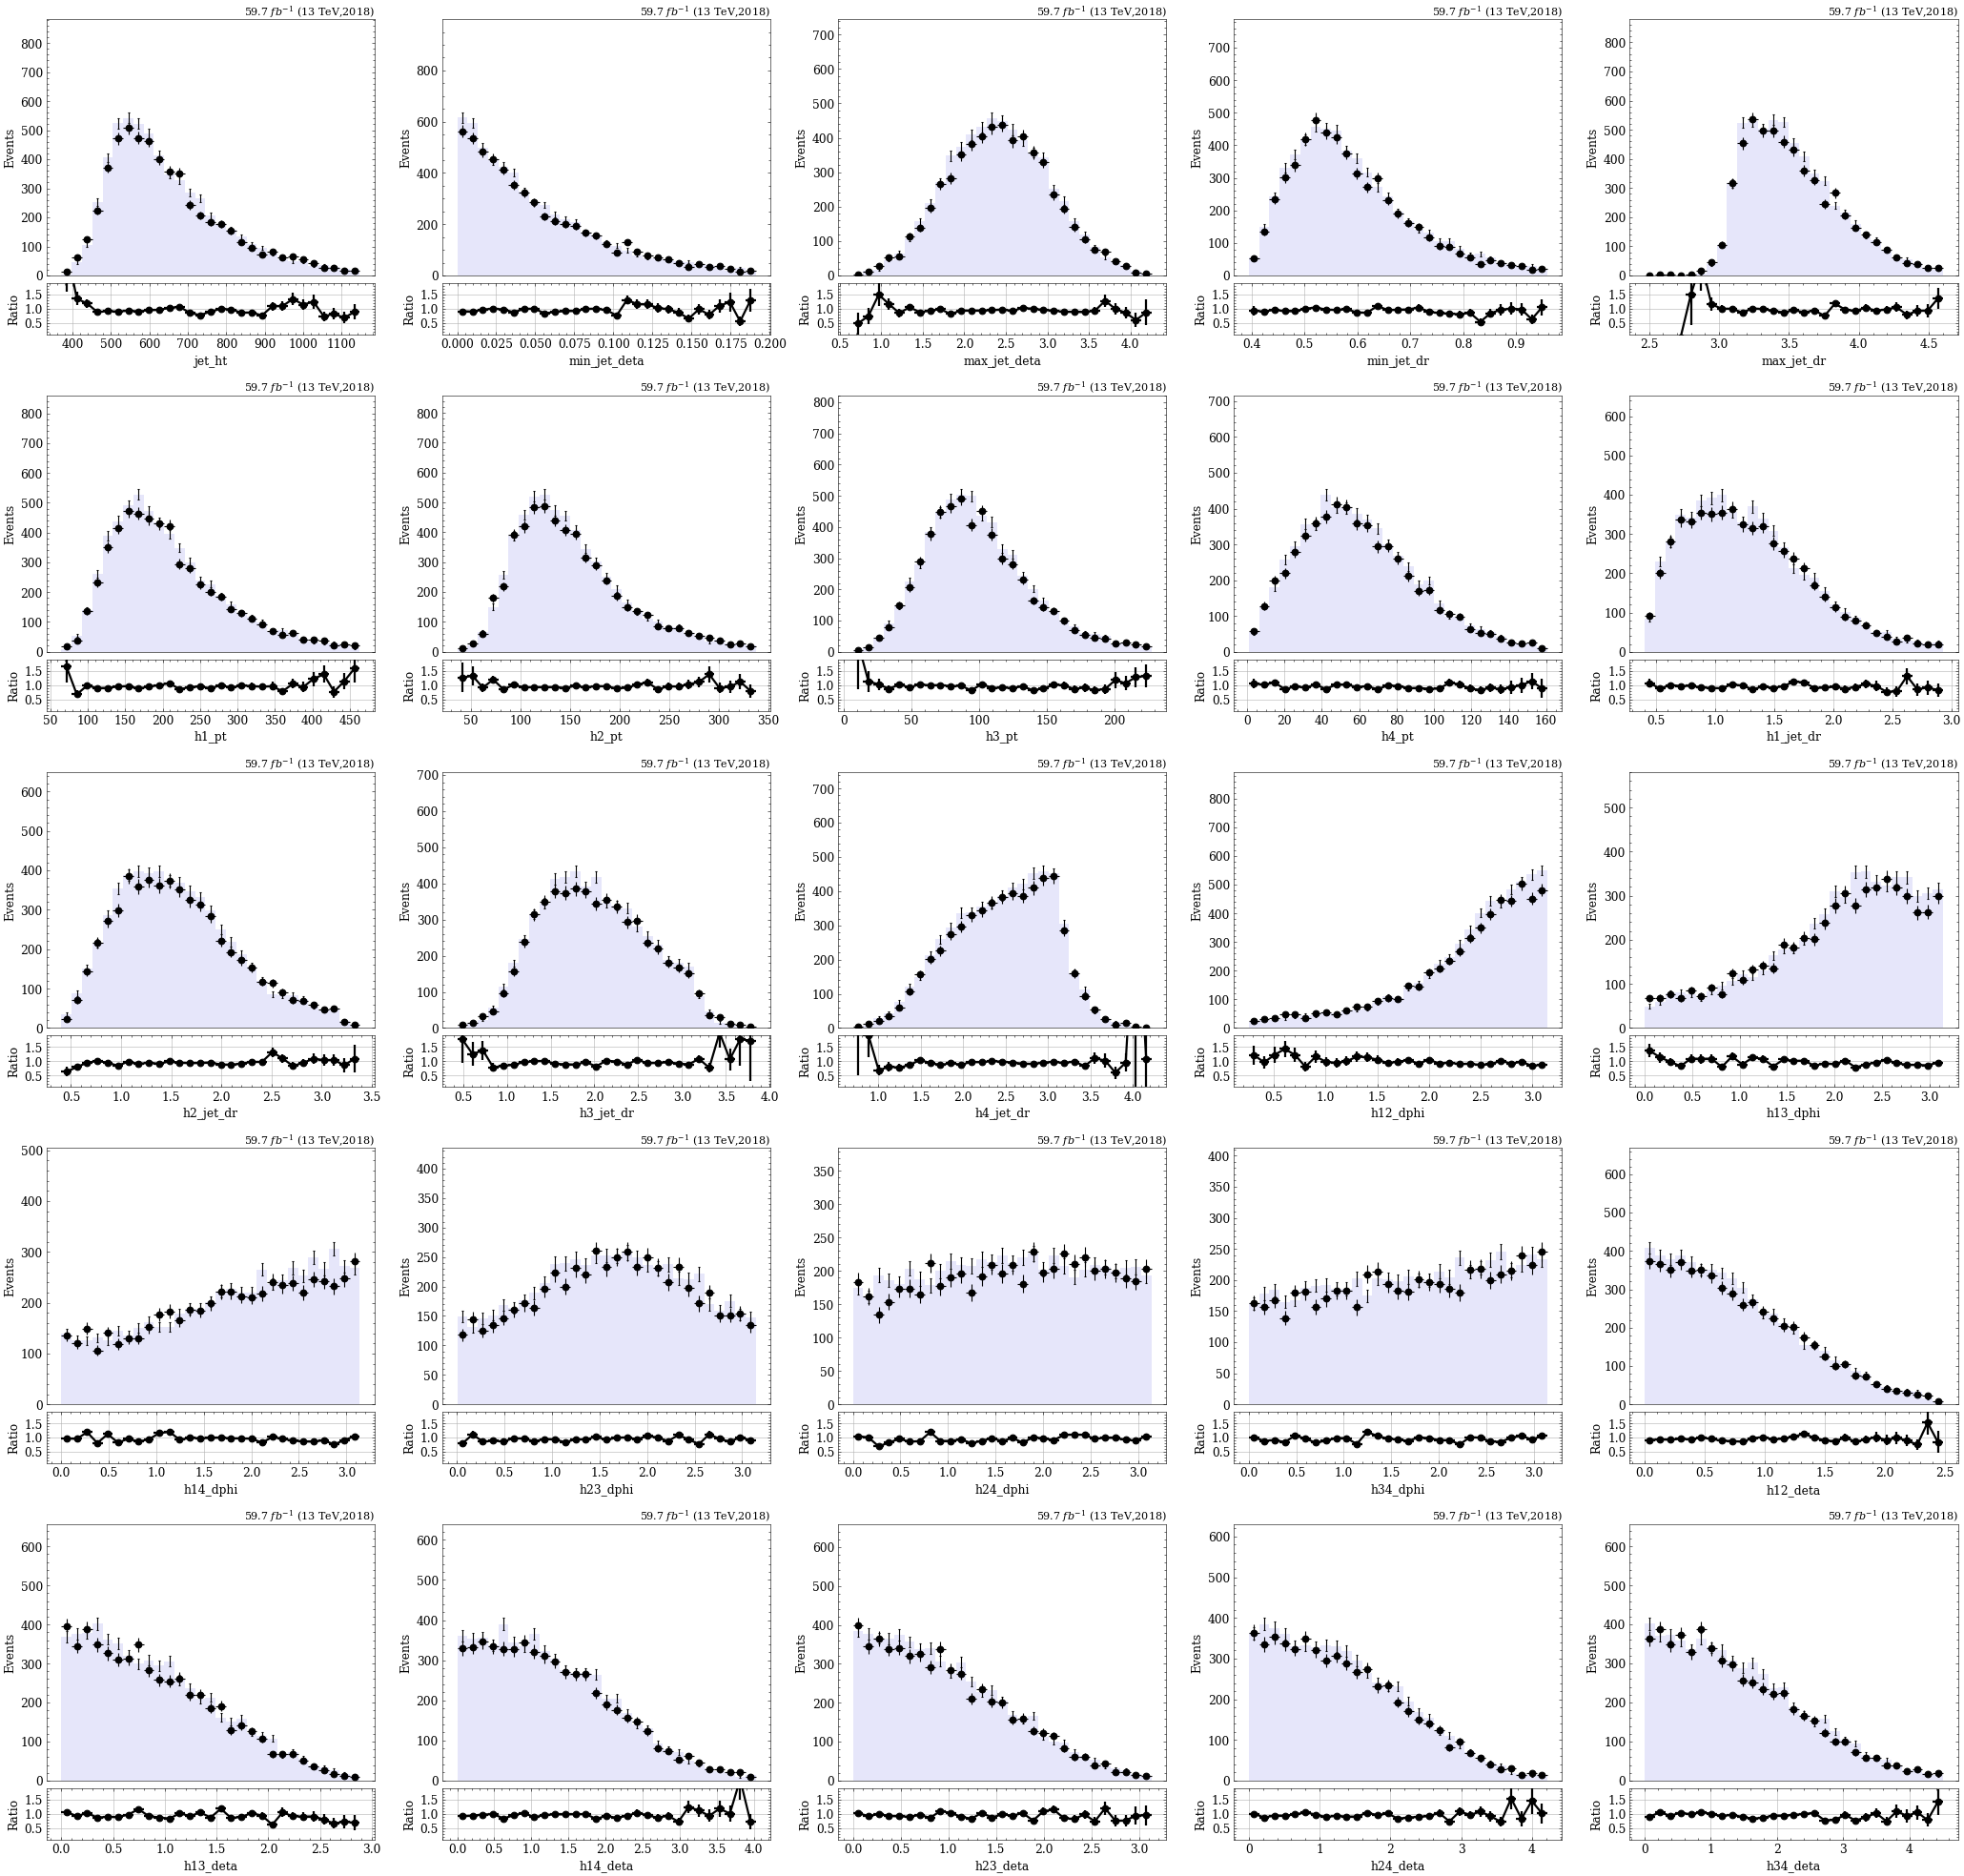

In [65]:
study.quick( 
    val_data+val_model,
    masks=[vr_bdt.a]+[vr_bdt.b],
    scale=[None]+[vr_bdt.reweight_tree],
    varlist=eightb.bdt_features,
    ratio=True,
)